## Star Data Prep
The stars displayed on the PANOTPES 3D app are from the Mag 5 Star Catalog by Dr. John P. Pratt (<a href="https://www.johnpratt.com/items/astronomy/mag_5_stars.html">johnpratt.com/items/astronomy/mag_5_stars.html</a>), which itself is a subset of the Yale Bright Star Catalog. The Mag 5 Star Catalog contains stars brighter than (or, less than) 5.5 visual magnitude*, totaling 3,923 stars.

Here, the columns relevant to render stars (converted RA+Dec\*\*, brightness, color, constellation) are exported into JS arrays, separated by magnitude:

- Magnitudes -1 to 0: `brightest_stars_arr`
- Magnitudes 1 to 2: `bright_stars_arr`
- Magnitudes 2 to 3: `average_stars_arr`
- Magnitudes 4 to 5: `faint_stars_arr`
- Magnitudes 6+: `faintest_stars_arr`

For rendering purposes, separate JS arrays allow the stars to easily be sized and made visible in stages after sunset.

The star brightness threshold may be increased as well, decreasing the number of stars displayed, in order to optimize app performance/FPS.

A small number of the stars are missing a B-V color, so for now, they will be replaced with 0.45 (roughly white on the B-V color index\*\*\*). Later on, these stars can be queried in SIMBAD and have this temporary value replaced with the proper one.

<small><small>\*Certain stars dimmer than this were kept in the catalog for meeting other criterea; see the webpage for more details
<br>
\*\*Each star's RA and Dec will be converted from spherical coordinates, and then Cartesian (x, y, z) for placement in the 3D scene.
<br>
\*\*\*See <a href="https://en.wikipedia.org/wiki/Color_index">en.wikipedia.org/wiki/Color_index</a></small></small>

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, pi
import numpy as np

In [34]:
# Set sky radius here, to match 3D scene
sky_radius = 3.65

In [35]:
# Import relevant columns from Mag 5 Star Catalog as dataframe

# Relevant columns are:
# [6] Constellation ID # (int)
# [8-10] RA HMS (int, int, float)
# [11] Dec hemisphere (string: 'N' or 'S')
# [12-14] Dec DMS (int)
# [15] Visual mag (float)
# [16] B-V color index (float)

cols = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
col_names = ['con', 'ra_h', 'ra_m', 'ra_s', 'hem', 'dec_d', 'dec_m', 'dec_s', 'vmag', 'bv']

stars = pd.read_table('mag_5_stars.csv', delimiter=',', usecols=cols, header=0, names=col_names)

In [40]:
# Create lists for all the stars, each entry being a list of parameters of a particular star
# Separate stars by magnitude

brightest_stars_arr = []
bright_stars_arr = []
average_stars_arr = []
faint_stars_arr = []
faintest_stars_arr = []


# Need these to convert RA and Dec

def ra_hms_to_dd(h, m, s):
    dd = (15*h) + (15*m/60) + (15*s/3600)
    return dd

def dec_dms_to_dd(d, m, s):
    dd = d + (m/60) + (s/3600)
    return dd

def deg_to_rad(deg):
    return deg * pi / 180.

def equatorial_to_cartesian(sky_radius, ra_rad, dec_rad, hem):
    '''Takes the following:
    sky_radius: arbitrary radius of sky in 3D scene. 
                (Best if a few decimal points smaller than actual radius, to avoid z-fighting)
                (should I just take the actual val and handle that in here?? ...whatever)
    ra_rad: RA in radians
    dec_rad: Dec in radians (MUST BE POSITIVE)
    hem: used to specify whether y-coord is + or - (if star is in N or S hemisphere)
         (Note: The y-axis in three.js is the conventional "up"/z-axis. 
         Conventional y and x are the x and z axes, respectively, in three.js)
    
    Returns x, y, z coordinates rounded to 4 decimal places.
    '''
    
    # Here, rho = distance from point to origin,
    # theta = equator angle around the vertical axis,
    # phi = angle from vertical/up axis.
    # Sign of phi must be flipped because RA goes clockwise, and phi goes counterclockwise.

    rho = sky_radius
    theta = ra_rad
    phi = pi/2. - dec_rad
    
    if hem == 'N':
        sign = 1
    elif hem == 'S':
        sign = -1

    z = round(rho * sin(phi) * cos(theta), 4)
    y = sign * round(rho * cos(phi), 4)
    x = round(rho * sin(phi) * sin(theta), 4)
    
    return x, y, z

In [45]:
# Iterate over all stars (rows in df) to extract each star's data
# Save this data in mag_5_stars.js
# Also log how many stars were missing B-V color data

count_missing_color = 0
for i in range(len(stars)):
    
    # Convert star RA HMS to decimal degrees; round to 4 decimals
    ra_h = stars['ra_h'].iloc[i]
    ra_m = stars['ra_m'].iloc[i]
    ra_s = stars['ra_s'].iloc[i]
    ra_dd = ra_hms_to_dd(ra_h, ra_m, ra_s)
    
    # Convert star Dec DMS to decimal degrees, w/ correct sign (+ -)
    dec_d = stars['dec_d'].iloc[i]
    dec_m = stars['dec_m'].iloc[i]
    dec_s = stars['dec_s'].iloc[i]
    dec_dd = dec_dms_to_dd(dec_d, dec_m, dec_s)
    
    # Convert RA and Dec to radians
    ra_rad = deg_to_rad(ra_dd)
    dec_rad = deg_to_rad(dec_dd)
    
    # Convert RA and Dec from equatorial to cartesian
    hem = stars['hem'].iloc[i]
    x, y, z = equatorial_to_cartesian(sky_radius, ra_rad, dec_rad, hem)
    
    # Get star visual mag, color, and constellation ID #
    vmag = stars['vmag'].iloc[i]
    color = stars['bv'].iloc[i]
    con = stars['con'].iloc[i]
    
    # Check that color data is not nan
    if color!=color:
        count_missing_color += 1
    color = 0.45 if color!=color else color
    
    # Each star will have data indexed in this order:
    star_data = [x, y, z, vmag, color, con]
    
    # Categorize star, save data to appropriate list
    if vmag < 1:
        # One of the brightest stars
        brightest_stars_arr.append(star_data)
        
    elif vmag < 2:
        
        # Star is bright
        bright_stars_arr.append(star_data)
        
    elif vmag < 3:
        # Average star
        average_stars_arr.append(star_data)
        
    elif vmag < 5:
        # Faint star
        faint_stars_arr.append(star_data)
        
    else:
        # One of the faintest stars
        faintest_stars_arr.append(star_data)


f = open('mag_5_stars.js', 'w')
f.write(f'brightest_stars_arr={brightest_stars_arr}\n\n')
f.write(f'bright_stars_arr={bright_stars_arr}\n\n')
f.write(f'average_stars_arr={average_stars_arr}\n\n')
f.write(f'faint_stars_arr={faint_stars_arr}\n\n')
f.write(f'faintest_stars_arr={faintest_stars_arr}')
f.close()

print('File save complete')
print(f'({count_missing_color} stars missing B-V data)')

File save complete
(61 stars missing B-V data)


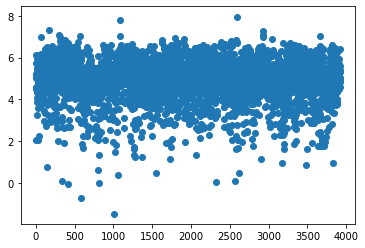

In [7]:
plt.scatter(range(len(stars_arr)), [stars_arr[i][3] for i in range(len(stars_arr))])

In [8]:
def ra_hm_to_dd(h, m):
    dd = (15*h) + (15*m/60)
    return dd

def dec_dm_to_dd(d, m):
    dd = d + (m/60)
    return dd